# Demo for using COMPAS output data files for local system

**A jupyter notebook that shows some examples of how to read in and use data from COMPAS simulations** 

Last updated by: Floor Broekgaarden 5 March 2019

This jupyter notebook is for when you run COMPAS locally (not on a cluster), which is usually the case when you just start with COMPAS or do small runs. The output files created by COMPAS then look like:



<div class="alert alert-block alert-info"> 
The 2 files below are most often used: <br>
    
**'doubleCompactObjects.txt'**  :  parameters of all the double compact objects (BH-BH, NS-NS, BH-NS and NS-BHs) created in COMPAS. Does not contain white dwarfs. <br>


**'systemParameters.txt'**  : all initial parameters of all binaries that are simulated with COMPAS <br>

But COMPAS also gives additional output files such as: <br>
**'supernovae.txt'**       :  parameters of all the SNe

In [1]:
from __future__ import division # in case you are using python 2
import h5py as h5 # hdf5 file library



import numpy as np
import matplotlib
import matplotlib.pyplot as plt


# Plotting settings:
from matplotlib import rc                                                                                                                                                                                                                    
from matplotlib import rcParams
rc('font', family='serif')

matplotlib.rcParams['xtick.major.size'] = 12
matplotlib.rcParams['ytick.major.size'] = 12
matplotlib.rcParams['xtick.minor.size'] = 8
matplotlib.rcParams['ytick.minor.size'] = 8
fs = 30   #  fontsize in plots 

In [2]:
# Read in data if you have a COMPASOutput.hdf5 file and use normal COMPAS (not STROOPWAFEL)

In [3]:
def maskTargetDCOs_local(pathname, DCOtype, boolDCOmask):
    """returns mask of DCO of interest
    pathname is location where 'doubleCompactObjects.txt' sits
    DCOtype is which DCO you want to select (between "ALL", "BHBH, NSNS, BHNS")
    boolDCOmask = [1,1,0] is whether to mask for [Hubble, RLOF, Pessimistic]:
        Hubble = 1 selects only DCOs that merge in a Hubble time
        RLOF = 1, selects DCOs that don't have RLOF after CE 
        Pessimistic = 0, selects optimistic binaries (see Dominik+2012 for definition)
    """

    # parameters needed for standard Flags. all these sit in doubleCompactObjects.txt
    M1 = obtainDataCOMPAS_local(param = ['M1', 'doubleCompactObjects.txt'], pathname = pathname)
    M2 = obtainDataCOMPAS_local(param = ['M2', 'doubleCompactObjects.txt'], pathname = pathname)
    stellarType1 = obtainDataCOMPAS_local(param = ['stellarType1', 'doubleCompactObjects.txt'], pathname = pathname)
    stellarType2 = obtainDataCOMPAS_local(param = ['stellarType2', 'doubleCompactObjects.txt'], pathname = pathname)
    mergesInHubbleTimeFlag = obtainDataCOMPAS_local(param = ['mergesInHubbleTimeFlag', 'doubleCompactObjects.txt'], pathname = pathname)    
    RLOFSecondaryAfterCEE = obtainDataCOMPAS_local(param = ['RLOFSecondaryAfterCEE', 'doubleCompactObjects.txt'], pathname = pathname)
    optimisticCEFlag = obtainDataCOMPAS_local(param = ['optimisticCEFlag', 'doubleCompactObjects.txt'], pathname = pathname)    
       
    # wanted additional flags for mask
    Hubble, RLOF, Pessimistic = boolDCOmask
    
    if (DCOtype == 'BNS') | (DCOtype == "NSNS"):
        mask0 = ((stellarType1 == 13) & (stellarType2 == 13))

    elif (DCOtype == 'BHNS') | (DCOtype == 'NSBH'):
        mask0 = ((stellarType1 == 13) & (stellarType2 == 14)) | \
            ((stellarType1 == 14) & (stellarType2 == 13) )          

    elif (DCOtype == 'BBH') | (DCOtype == 'BHBH'):
        mask0 = ((stellarType1 == 14) & (stellarType2 == 14))
        
    elif (DCOtype == 'all') | (DCOtype == 'ALL') :
        mask0 = ((stellarType1 == 14) | (stellarType1 == 13))
    else:
        print('error: DCOtype that you entered ', DCOtype, ' not known')
     
    
    if Hubble:     # if True only keep DCO that merge in a Hubble time
        mask1 = (mergesInHubbleTimeFlag==True) 
    else:
        mask1 = (mergesInHubbleTimeFlag==True) |  (mergesInHubbleTimeFlag==False) 

    if RLOF:     # RLOF mask 
        mask2 = (RLOFSecondaryAfterCEE==False) | (RLOFSecondaryAfterCEE==True)
    else:
        mask2 = (RLOFSecondaryAfterCEE==False) | (RLOFSecondaryAfterCEE==True)

    if Pessimistic:      # Pessimistic mask :  mask systems that have optimistic CE flag?
        mask3 = np.logical_not(optimisticCEFlag==1)
    else:
        mask3 = np.logical_not(optimisticCEFlag== 1) + \
        np.logical_not(optimisticCEFlag == 0)   

        
    combinedMask = mask0 * mask1 * mask2 * mask3
    
    
    return combinedMask


def obtainDataCOMPAS_local(param, pathname):
    """returns requested parameter from COMPAS datafile 
    requested parameter is assigned using 
    param = ['var name', 'name of .txt file that parameter is in']
    pathdisk is the location of the .txt data file
    
    an example is: obtainDataCOMPAS_local(param = \
    ['M1', 'doubleCompactObjects.txt', ], \
    pathname = '/Volumes/TOSHIBA EXT/ExampleDataCOMPAS_local/')"""
    
    
    xparam, xparam_filename = param

    data = np.genfromtxt(pathname + xparam_filename, skip_header=2, names = True)
    xvalues           = data[xparam]

    return xvalues




def plothistogram(var, varlabel, title):
    '''plot histogram of var'''
    
    f, ax = plt.subplots(1, 1,  figsize=(10,10)) 
    
    ax.hist(var, 30, lw = 3, histtype = 'stepfilled')
    ax.set_xlabel(varlabel[0] , fontsize = fs)
    ax.set_ylabel(varlabel[1] , fontsize = fs)
    ax.set_title(title, fontsize = fs)
    ax.grid(True)
    ax.tick_params(labelsize=fs)
    
    return ax

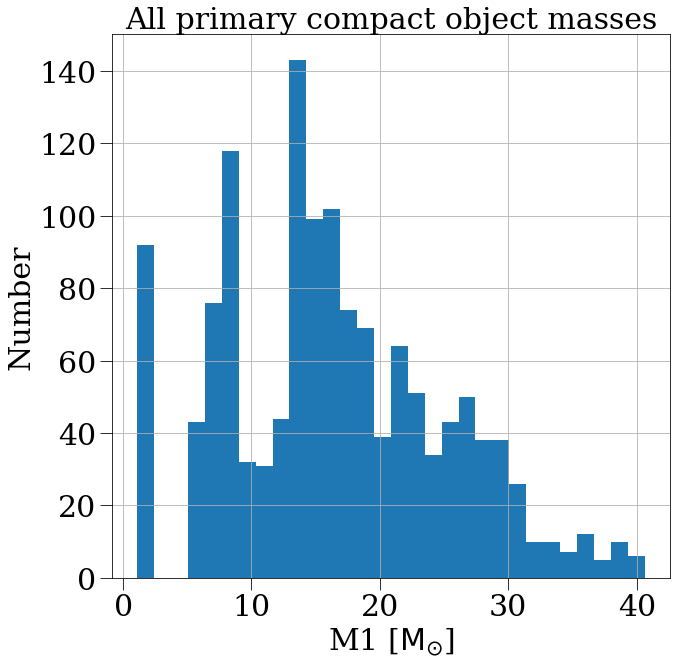

In [4]:
# obtain the mass of the primary compact object of all DCO mergers: 
# this parameter, 'M1' sits in the file 'doubleCompactObjects': ['tc', 'doubleCompactObjects']
M1 = obtainDataCOMPAS_local(param = ['M1', 'doubleCompactObjects.txt', ], \
                            pathname = '/Volumes/TOSHIBA EXT/ExampleDataCOMPAS_local/')

plothistogram(M1, varlabel = [r'M1 [$\rm{M}_{\odot}$]', r'Number'], title = 'All primary compact object masses')

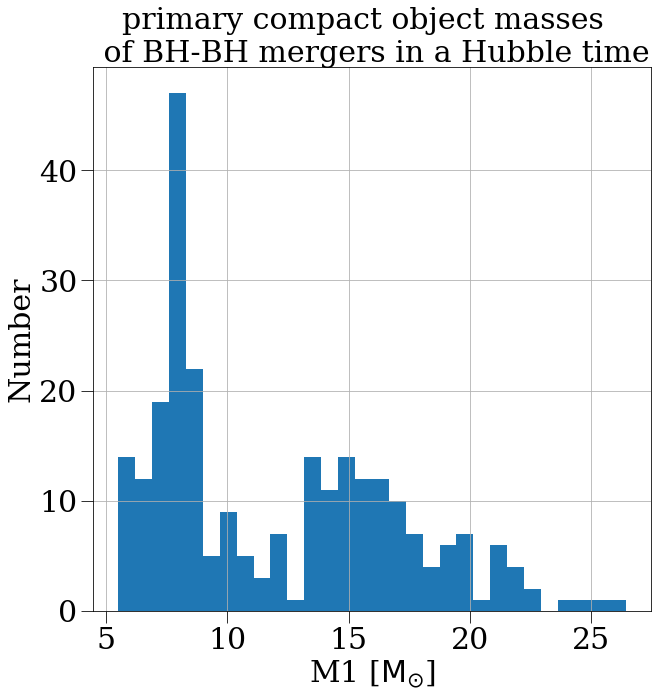

In [5]:
# now mask for example only the BH-BHs that merge in a Hubble time

pathdir ='/Volumes/TOSHIBA EXT/ExampleDataCOMPAS_local/'


M1 = obtainDataCOMPAS_local(param = ['M1', 'doubleCompactObjects.txt', ], pathname = pathdir)
maskBBHinaHubble = maskTargetDCOs_local(pathname = pathdir, DCOtype = 'BBH', boolDCOmask = [1,1,0])

plothistogram(M1[maskBBHinaHubble], varlabel = [r'M1 [$\rm{M}_{\odot}$]', r'Number'], \
              title = 'primary compact object masses  \n of BH-BH mergers in a Hubble time')